# **LTP**

## Markdown program for close to expiration products
# **Supervised classification model**
---
#### Pratical case
#### 02/03/2025
---

# Description of the supervised modeling project

The use of pink labels is a strategy employed in the retail sector to reduce losses and increase revenue when items are nearing the end of their shelf life, boosting sales of these items in depreciation periods by applying a discount to the original selling price (pvp) which is printed on a pink label and applied to each item.

This notebook describes the development of a predictive classification model, capable of predicting whether a product will sell, taking into account its discount rate and its characteristics, with a set of data provided by an LTP client company.  

The data for analysis was provided in two distinct, related datasets, one with data on the depreciation period of the items, and a second set of data on the stores where these items were labeled.  

Both sets of data were previously analyzed and transformed in order to prepare them for modelling, correcting incongruent, misplaced or missing values.

Variables associated with labeling and setting the depreciation period for each item:
* Idstore - Store that printed the label
* SKU - SKU code for the label
* Brand - SKU brand
* Oldpvp - Price before depreciation period
* Newpvp (discount) - Price applied to the label and (discount applied)
* Labelqty - Number of labels applied (always one per observation)
* Weight - Weight of each SKU in grams (g)
* Payment_method - Payment method used
* Margin (%) - Profit percentage
* Profit (€) - Profit in euros (€)
* perc_expiration_sku - Proportion of shelf life remaining at the time of labeling
* expiring_date - Expiry date of the article
* labeling_date - Date of labeling
* sell_date - Sale date of the labeled item
* sold - Assigns a value of 1 to products sold before the expiry date, and 0 to products not sold in time

Descriptive variables for each store where labels were printed:
* Idstore - Store that printed the label
* type - Store size
* selling_square_ft - sales area of the store
* district - District where the store is located

# Import libraries

In [10]:
import pandas as pd #data processing
import numpy as np #linear algebra
import os #reading the input files
import matplotlib.pyplot as plt #data visualization
import seaborn as sns #data visualization
from sklearn.impute import SimpleImputer # Import SimpleImputer
import datetime 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import dataset

In [11]:
path = r'C:\Users\macn1\Documents\EDITDSBA\10_Projeto_Final\Modelo_Clusterização\merged_data.xlsx'
dataset = pd.read_excel(path)
df = pd.DataFrame(dataset)

df.head()

,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,profit (€),perc_expiring_sku,perc_interval,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,0.3376,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,0.3168,0.005025,[0 - 10%[,2021-10-02,2021-10-01,NaT,199,NaN,1,False
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,0.3792,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,0.3360,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,0.3696,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True


In [12]:
# Renames feature 'profit (€)' to 'lucro_expectável'
df = df.rename(columns={'profit (€)': 'expected_profit'})

print(df.columns)

Index(['idstore', 'district', 'selling_square_ft', 'type', 'sku', 'brand',
       'oldpvp', 'new_pvp', 'discount', 'discount%interval', 'labelqty',
       'weight (g)', 'payment_method', 'margin (%)', 'margin%interval',
       'expected_profit', 'perc_expiring_sku', 'perc_interval',
       'expiring_date', 'labelling_date', 'sell_date', 'expiring_days',
       'period_sell_vs_labelling', 'period_expiring_vs_labelling', 'sold'],
      dtype='object')


# Dataset description

In [13]:
#Dataset statistical information
df.describe()

,idstore,selling_square_ft,sku,oldpvp,new_pvp,discount,labelqty,weight (g),margin (%),expected_profit,perc_expiring_sku,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling
count,149221.000000,149221.000000,149221.000000,149221.000000,149221.000000,149221.000000,149221.0,148797.000000,149221.00000,149221.000000,149221.000000,149221,149221,80069,149221.000000,80069.000000,149221.000000
mean,139.006541,5703.485180,163.757661,1.573065,1.095615,0.302257,1.0,163.448114,15.82739,0.174481,0.384930,2021-10-18 04:20:30.293323008,2021-10-16 16:46:21.163509504,2021-10-17 18:33:32.734016768,6.302980,0.926139,1.482050
min,1.000000,10.000000,1.000000,0.590000,0.340000,0.010000,1.0,1.000000,10.00000,0.034000,0.000000,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,1.000000,0.000000,0.000000
25%,58.000000,1108.000000,99.000000,1.190000,0.830000,0.300000,1.0,123.000000,13.00000,0.124500,0.200000,2021-10-11 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,3.000000,0.000000,1.000000
50%,135.000000,4641.000000,160.000000,1.590000,1.110000,0.300000,1.0,166.000000,17.00000,0.152900,0.333333,2021-10-19 00:00:00,2021-10-17 00:00:00,2021-10-18 00:00:00,3.000000,1.000000,1.000000
75%,212.000000,8329.000000,236.000000,1.890000,1.320000,0.300000,1.0,192.000000,19.00000,0.222400,0.666667,2021-10-26 00:00:00,2021-10-25 00:00:00,2021-10-25 00:00:00,5.000000,1.000000,2.000000
max,332.000000,25258.000000,319.000000,17.990000,8.990000,0.510000,1.0,410.000000,20.00000,1.438400,1.000000,2021-11-20 00:00:00,2021-10-31 00:00:00,2021-11-18 00:00:00,359.000000,20.000000,25.000000
std,87.187436,5460.133613,87.316180,0.569421,0.394158,0.036908,0.0,57.806210,3.30236,0.076051,0.222710,NaN,NaN,NaN,20.730896,0.831911,1.322699


In [14]:
#Statistical information from dataset
#Lists the variables of a pandas DataFrame by data type
def list_variables_by_type(df):
    data_types = df.dtypes
    variables_by_type = {}

    for column, type in data_types.items():
        if type not in variables_by_type:
            variables_by_type[type] = []
        variables_by_type[type].append(column)

    for type, variables in variables_by_type.items():
        print(f'Variables of type {type}:')
        print(variables)
        print('-' * 20)


list_variables_by_type(df)

Variables of type int64:
['idstore', 'selling_square_ft', 'sku', 'labelqty', 'margin (%)', 'expiring_days', 'period_expiring_vs_labelling']
--------------------
Variables of type object:
['district', 'type', 'brand', 'discount%interval', 'payment_method', 'margin%interval', 'perc_interval']
--------------------
Variables of type float64:
['oldpvp', 'new_pvp', 'discount', 'weight (g)', 'expected_profit', 'perc_expiring_sku', 'period_sell_vs_labelling']
--------------------
Variables of type datetime64[ns]:
['expiring_date', 'labelling_date', 'sell_date']
--------------------
Variables of type bool:
['sold']
--------------------


In [15]:
#Lists the variables of a pandas DataFrame by data type and converts datetime64[ns] to date.
def list_variables_by_type(df):
    data_types = df.dtypes
    variables_by_type = {}

    for column, type in data_types.items():
        if type == 'datetime64[ns]':
            df[column] = df[column].dt.date
            type = 'object' # Update type to object (date)

        if type not in variables_by_type:
            variables_by_type[type] = []
        variables_by_type[type].append(column)

    for type, variables in variables_by_type.items():
        print(f'Variables of type {type}:')
        print(variables)
        print('-' * 20)

list_variables_by_type(df)

Variables of type int64:
['idstore', 'selling_square_ft', 'sku', 'labelqty', 'margin (%)', 'expiring_days', 'period_expiring_vs_labelling']
--------------------
Variables of type object:
['district', 'type', 'brand', 'discount%interval', 'payment_method', 'margin%interval', 'perc_interval']
--------------------
Variables of type float64:
['oldpvp', 'new_pvp', 'discount', 'weight (g)', 'expected_profit', 'perc_expiring_sku', 'period_sell_vs_labelling']
--------------------
Variables of type object:
['expiring_date', 'labelling_date', 'sell_date']
--------------------
Variables of type bool:
['sold']
--------------------


In [16]:
df.head()

,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,expected_profit,perc_expiring_sku,perc_interval,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,0.3376,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,0.3168,0.005025,[0 - 10%[,2021-10-02,2021-10-01,NaT,199,NaN,1,False
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,0.3792,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,0.3360,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,0.3696,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True


In [17]:
# Check for null values in the dataset
data = df.replace(r'^\s*$', np.nan, regex=True)
print('\nNull values in Data_labels:')
print(data.isnull().sum())


Null values in Data_labels:
idstore                             0
district                            0
selling_square_ft                   0
type                                0
sku                                 0
brand                               0
oldpvp                              0
new_pvp                             0
discount                            0
discount%interval                   0
labelqty                            0
weight (g)                        424
payment_method                  69152
margin (%)                          0
margin%interval                     0
expected_profit                     0
perc_expiring_sku                   0
perc_interval                       0
expiring_date                       0
labelling_date                      0
sell_date                       69152
expiring_days                       0
period_sell_vs_labelling        69152
period_expiring_vs_labelling        0
sold                                0
dtype: int64


In [18]:
# Check for duplicate values in the dataset
print('\nDuplicate values:')
print(data.duplicated().sum())


Duplicate values:
79604


In [19]:
# Count all occurrences of duplicates
duplicate_count = data[data.duplicated(subset=['sku', 'brand', 'new_pvp', 'discount','sold'], keep=False)].groupby(['sku', 'brand', 'new_pvp', 'discount','sold']).size().sort_values(ascending=False)

print(duplicate_count)

sku  brand   new_pvp  discount  sold 
227  marca2  1.11     0.30      True     6639
105  marca2  1.04     0.30      True     4965
8    marca2  0.83     0.30      True     3444
251  marca2  0.83     0.30      True     3267
99   marca2  0.83     0.30      True     3177
                                         ... 
290  marca2  0.64     0.50      False       2
12   marca2  1.04     0.25      True        2
11   marca4  2.09     0.30      True        2
1    marca1  2.31     0.50      True        2
5    marca4  2.09     0.25      False       2
Length: 1078, dtype: int64


* These observations are not duplicates, so they correspond to the number of sales of the same item.

In [20]:
skus_uniques = data['sku'].unique()

# Printing the unique sku values
print(skus_uniques)

[  1   8  27  43  54  99 104 112 127 139 173 198 202 211 212 213 219 251
 278 302 304   2   3  10  17  28  31  42  44  46  61  65  69  76  77  79
  81  89  92  95 105 109 113 123 131 138 156 157 162 172 178 189 191 194
 195 200 203 227 232 237 242 248 255 256 259 272 279 284 291 293 294 306
   4   7  12  25  36  37  86 141 193 231 234 247 257 303  29  35  48  58
  66  84  98 102 118 121 130 145 165 236 254 264 281 286 292 309  34  41
  51  70  72 119 129 135 164 170 204 241 277 288  23 163 201  63  82 160
 249  47 114 117 126 168 187 222 260 261 280 301 285 296  68 174 315 246
 266 318  33  49 199 310 143 154 223 245 298 240 206 314 268 155 305  16
 152 224  96 103 146 101 133   6  13 250 159 184 238 239  18 282 140  85
 161 317  52 290   5  11  22  24  39  55  59  62  90  94 115 116 124 128
 142 151 158 179 180 183 186 190 217 218 221 229 230 262   9  19  88 148
 185 188 196 207 253 265 270 276  21  32  50  53  64  74  75  97 216  71
  80 136 166 226 263 267 274 297 300 316 205 107 16

In [21]:
count = data.groupby('brand')['sku'].value_counts()

# Printing the count
print(count)

brand    sku
marca1   1       14
marca10  22      28
marca11  26      10
marca12  43     550
         278    322
               ... 
marca9   63      18
         311     14
         23      13
         18      10
         210      8
Name: count, Length: 307, dtype: int64


In [22]:
# SKUs of each 'brand'  
unique_skus_per_brand = data.groupby('brand')['sku'].unique()

# Printing the list of unique SKUs per brand
print(unique_skus_per_brand)

brand
marca1                                                   [1]
marca10                                                 [22]
marca11                                                 [26]
marca12               [27, 43, 278, 120, 150, 153, 275, 197]
marca13                                                 [29]
marca14                                                 [33]
marca15              [157, 162, 248, 259, 284, 294, 130, 34]
marca16                   [164, 184, 273, 308, 271, 40, 287]
marca17                                                 [41]
marca18    [62, 124, 128, 142, 183, 186, 218, 229, 230, 1...
marca19                                                 [52]
marca2     [8, 54, 99, 104, 127, 139, 173, 198, 202, 213,...
marca20                                                 [56]
marca21    [59, 90, 94, 116, 158, 262, 188, 253, 276, 136...
marca22                   [249, 206, 85, 161, 317, 144, 106]
marca23                             [70, 199, 143, 159, 263]
marca24           

# New features

In [23]:
data.head()

,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,expected_profit,perc_expiring_sku,perc_interval,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,0.3376,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,0.3168,0.005025,[0 - 10%[,2021-10-02,2021-10-01,NaT,199,NaN,1,False
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,0.3792,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,0.3360,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,0.3696,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True


## Average expected profit per sku over the last 3 days

In [24]:
#Adds a feature with the average of 'expected_profit' over the last 3 days per 'sku'.
def add_average_profit_3days_per_sku(df):
    # Ensures that the 'labelling_date' column is of type datetime
    df['labelling_date'] = pd.to_datetime(df['labelling_date']).dt.date

    # Groups by 'sku' and 'labelling_date' and calculates the average of the 'expected_profit'
    df_grouped = df.groupby(['sku', 'labelling_date'])['expected_profit'].mean().reset_index()

    # Sort the grouped DataFrame by 'sku' and 'labelling_date'
    df_grouped = df_grouped.sort_values(by=['sku', 'labelling_date'])

    # Function to calculate the average of the last 3 days excluding the current day
    def calculate_average(group):
        medias = group['expected_profit'].rolling(window=4, min_periods=1).mean().shift(1)
        medias.fillna(0, inplace=True) # Fill NaN with 0
        return medias

    # Calculates the average of the last 3 days by sku
    df_grouped['average_profit_3days_sku'] = df_grouped.groupby('sku').apply(calculate_average).reset_index(level=0, drop=True)

    # Merge with the original DataFrame
    df = pd.merge(df, df_grouped[['sku', 'labelling_date', 'average_profit_3days_sku']], on=['sku', 'labelling_date'], how='left')

    return df

data = add_average_profit_3days_per_sku(data)
data.head()

C:\Users\macn1\AppData\Local\Temp\ipykernel_2148\205303681.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped['average_profit_3days_sku'] = df_grouped.groupby('sku').apply(calculate_average).reset_index(level=0, drop=True)


,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,perc_expiring_sku,perc_interval,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,0.005025,[0 - 10%[,2021-10-02,2021-10-01,NaT,199,NaN,1,False,0.0
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0


## Discount plus 10 %

In [25]:
# Creates the new column 'discount_plus_10%'
data['discount_plus_10%'] = data['discount'] + 0.10

# Display the first few rows of the DataFrame to check the result
data.head()

,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,perc_interval,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,[0 - 10%[,2021-10-02,2021-10-01,NaT,199,NaN,1,False,0.0,0.6
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6


## Discount plus 5 %

In [26]:
# Creates the new column 'discount_plus_5%'
data['discount_plus_5%'] = data['discount'] + 0.05

# Display the first lines of the DataFrame to check the result
data.head()

,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%,discount_plus_5%
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6,0.55
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,2021-10-02,2021-10-01,NaT,199,NaN,1,False,0.0,0.6,0.55
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6,0.55
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6,0.55
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6,0.55


## Region

In [27]:
# Get unique values from the 'district' column
unique_values = data['district'].unique()

# Convert the NumPy array to a list
unique_values_list = unique_values.tolist()

print(unique_values_list)

['Évora', 'Bragança', 'Lisboa', 'Porto', 'Coimbra', 'Guarda', 'Vila Real', 'Faro', 'Beja', 'Leiria', 'Viana do Castelo', 'Castelo Branco', 'Santarém', 'Setúbal', 'Portalegre', 'Aveiro', 'Braga', 'Viseu']


In [28]:
dist_list = {'district': ['Évora', 'Bragança', 'Lisboa', 'Porto', 'Coimbra', 'Guarda', 'Vila Real', 'Faro', 'Beja', 'Leiria', 'Viana do Castelo', 'Castelo Branco', 'Santarém', 'Setúbal', 'Portalegre', 'Aveiro', 'Braga', 'Viseu']}
df = pd.DataFrame(dist_list)

# Dictionary for mapping districts to regions
regions = {
    'Lisboa': 'Lisbon',
    'Porto': 'Porto',
    'Viana do Castelo':'Northern Region',
    'Braga':'Northern Region',
    'Bragança':'Northern Region',
    'Vila Real':'Northern Region',
    'Viseu': 'Central Region',
    'Guarda': 'Central Region',
    'Coimbra': 'Central Region',
    'Aveiro': 'Central Region',
    'Leiria': 'Central Region',
    'Castelo Branco': 'Central Region',
    'Portalegre': 'Southern Region',
    'Santarém': 'Southern Region',
    'Évora': 'Southern Region',
    'Setúbal': 'Southern Region',
    'Beja': 'Southern Region',
    'Faro': 'South Region'}

# Create the 'region' column using the map function
df['region'] = df['district'].map(regions)

cont=data['district'].count()
print(cont)
# Display the resulting DataFrame
print(df)

149221
            district           region
0              Évora  Southern Region
1           Bragança  Northern Region
2             Lisboa           Lisbon
3              Porto            Porto
4            Coimbra   Central Region
5             Guarda   Central Region
6          Vila Real  Northern Region
7               Faro     South Region
8               Beja  Southern Region
9             Leiria   Central Region
10  Viana do Castelo  Northern Region
11    Castelo Branco   Central Region
12          Santarém  Southern Region
13           Setúbal  Southern Region
14        Portalegre  Southern Region
15            Aveiro   Central Region
16             Braga  Northern Region
17             Viseu   Central Region


In [29]:
# Get unique values from the 'district' column
unique_values = df['region'].to_list()
cont=df['region'].count()

print(unique_values)
print(cont)

['Southern Region', 'Northern Region', 'Lisbon', 'Porto', 'Central Region', 'Central Region', 'Northern Region', 'South Region', 'Southern Region', 'Central Region', 'Northern Region', 'Central Region', 'Southern Region', 'Southern Region', 'Southern Region', 'Central Region', 'Northern Region', 'Central Region']
18


In [30]:
# Dataset 1 (df1)
data1 = data
df1 = pd.DataFrame(data1)

# Dataset 2 (df2) - Contains the column we want to add
df = {'district': ['Évora', 'Bragança', 'Lisboa', 'Porto', 'Coimbra', 'Guarda', 'Vila Real', 'Faro', 'Beja', 'Leiria', 'Viana do Castelo', 'Castelo Branco', 'Santarém', 'Setúbal', 'Portalegre', 'Aveiro', 'Braga', 'Viseu']
,
         'region': ['Southern Region', 'Northern Region', 'Lisbon', 'Porto', 'Central Region', 'Central Region', 'Northern Region', 'South Region', 'Southern Region', 'Central Region', 'Northern Region', 'Central Region', 'Southern Region', 'Southern Region', 'Southern Region', 'Central Region', 'Northern Region', 'Central Region']
}

df2 = pd.DataFrame(df)

# Merge the DataFrames
df_merged = pd.merge(df1, df2, on='district', how='inner')

# Find the index of the 'district' column
indice_district = df_merged.columns.get_loc('district')

# Insert the 'region' column after the 'district' column
df_merged.insert(indice_district + 1, 'region', df_merged.pop('region'))

df_merged.head()

,idstore,district,region,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,...,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%,discount_plus_5%
0,1,Évora,Southern Region,4762,Large,1,marca1,4.22,2.11,0.5,...,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6,0.55
1,1,Évora,Southern Region,4762,Large,1,marca1,3.96,1.98,0.5,...,2021-10-02,2021-10-01,NaT,199,NaN,1,False,0.0,0.6,0.55
2,1,Évora,Southern Region,4762,Large,1,marca1,4.74,2.37,0.5,...,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6,0.55
3,1,Évora,Southern Region,4762,Large,1,marca1,4.20,2.10,0.5,...,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6,0.55
4,1,Évora,Southern Region,4762,Large,1,marca1,4.62,2.31,0.5,...,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6,0.55


## Average shelf life 3 days previous

In [31]:
# Adds a column with the average of 'period_expiring_vs_labelling' over the last 3 days by 'sku'.
def add_average_shelf_life_3days_prev(df):
    # Group by 'sku' and 'labelling_date' and calculate the average of 'period_expiring_vs_labelling'
    df_grouped = df.groupby(['sku', 'labelling_date'])['period_expiring_vs_labelling'].mean().reset_index()

    # Sort the grouped DataFrame by 'sku' and 'labelling_date'
    df_grouped = df_grouped.sort_values(by=['sku', 'labelling_date'])

    # Function to calculate the average of the last 3 days without including the current date
    def calculate_average(row):
        sku = row['sku']
        reference_date = row['labelling_date']
        date_3_days_prev = reference_date - datetime.timedelta(days=3)

        df_filtered = df_grouped[(df_grouped['sku'] == sku) & (df_grouped['labelling_date'] < reference_date) & (df_grouped['labelling_date'] >= date_3_days_prev)]

        if len(df_filtered) >= 3:
            return df_filtered['period_expiring_vs_labelling'].mean()
        else:
            return 0

    # Apply the function to calculate the mean and create the new column
    df_grouped['average_shelf_life_3days_prev'] = df_grouped.apply(calculate_average, axis=1)

    # Merge with the original DataFrame
    df = pd.merge(df, df_grouped[['sku', 'labelling_date', 'average_shelf_life_3days_prev']], on=['sku', 'labelling_date'], how='left')

    return df

df_merged = add_average_shelf_life_3days_prev(df_merged)
df_merged.head()

,idstore,district,region,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,...,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%,discount_plus_5%,average_shelf_life_3days_prev
0,1,Évora,Southern Region,4762,Large,1,marca1,4.22,2.11,0.5,...,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0
1,1,Évora,Southern Region,4762,Large,1,marca1,3.96,1.98,0.5,...,2021-10-01,NaT,199,NaN,1,False,0.0,0.6,0.55,0.0
2,1,Évora,Southern Region,4762,Large,1,marca1,4.74,2.37,0.5,...,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0
3,1,Évora,Southern Region,4762,Large,1,marca1,4.20,2.10,0.5,...,2021-10-01,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0
4,1,Évora,Southern Region,4762,Large,1,marca1,4.62,2.31,0.5,...,2021-10-01,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0


## Weekday

In [32]:
# Try converting the column to datetime, treating errors as NaN
df_merged['labelling_date'] = pd.to_datetime(df_merged['labelling_date'], errors='coerce')

# Creates the new column ‘weekday’ with the day of the week
df_merged['weekday'] = df_merged['labelling_date'].dt.day_name()

# Find the index of the ‘labelling_date’ column
index_labelling_date = df_merged.columns.get_loc('labelling_date')

# Extract from column ‘weekday’
dia_da_semana = df_merged.pop('weekday')

# Insert the column ‘week_day’ after 'labelling_date'
df_merged.insert(index_labelling_date + 1, 'weekday', dia_da_semana)

df_merged.head(10)

,idstore,district,region,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,...,weekday,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%,discount_plus_5%,average_shelf_life_3days_prev
0,1,Évora,Southern Region,4762,Large,1,marca1,4.22,2.11,0.5,...,Friday,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0
1,1,Évora,Southern Region,4762,Large,1,marca1,3.96,1.98,0.5,...,Friday,NaT,199,NaN,1,False,0.0,0.6,0.55,0.0
2,1,Évora,Southern Region,4762,Large,1,marca1,4.74,2.37,0.5,...,Friday,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0
3,1,Évora,Southern Region,4762,Large,1,marca1,4.20,2.10,0.5,...,Friday,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0
4,1,Évora,Southern Region,4762,Large,1,marca1,4.62,2.31,0.5,...,Friday,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0
5,1,Évora,Southern Region,4762,Large,1,marca1,4.62,2.31,0.5,...,Friday,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0
6,1,Évora,Southern Region,4762,Large,1,marca1,3.42,1.71,0.5,...,Friday,2021-10-02,199,1.0,1,True,0.0,0.6,0.55,0.0
7,1,Évora,Southern Region,4762,Large,1,marca1,3.62,1.81,0.5,...,Friday,2021-10-02,199,1.0,1,True,0.0,0.6,0.55,0.0
8,1,Évora,Southern Region,4762,Large,1,marca1,4.62,2.31,0.5,...,Friday,NaT,199,NaN,1,False,0.0,0.6,0.55,0.0
9,1,Évora,Southern Region,4762,Large,1,marca1,4.38,2.19,0.5,...,Friday,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0


## Group brand variables in the 'other brands' category

In [33]:
# Group by 'brand' and 'sold' and count the observations
count_by_brand_and_sold = df_merged.groupby(['brand', 'sold']).size().unstack(fill_value=0)

# Print the count table
print('Count of observations by brand and value of ‘sold’:')
print(count_by_brand_and_sold)

Count of observations by brand and value of ‘sold’:
sold     False  True 
brand                
marca1       3     11
marca10      9     19
marca11      5      5
marca12    803    904
marca13    103     10
marca14      1      1
marca15   8588   3910
marca16    124     61
marca17    189     69
marca18     38     43
marca19      5      0
marca2   40556  65100
marca20     58     24
marca21    400     80
marca22     52     78
marca23     68     43
marca24     35     26
marca25    736    543
marca26    303    167
marca27     24     47
marca28    423    302
marca29     96     79
marca3     428    452
marca31      8      1
marca32     28     20
marca33    642    204
marca34      0      1
marca35      0      1
marca36      8      0
marca37      6      2
marca38      2      0
marca39      1      3
marca4     355    158
marca40     46     27
marca41     53     40
marca42      1      1
marca5    3423   1951
marca6     105    121
marca7   10382   4945
marca8     322    217
marca9     723    403


* The brands [marca14; marca19; marca31; marca34; marca35; marca36; marca38; marca39; marca42] do not have enough observations in the dataset to carry out a stratified train/test/split, so they will be grouped in a category called 'other brands'.

In [34]:
# Get unique values from the 'brand' column
unique_values = df_merged['brand'].unique()

# Convert the NumPy array to a list
list_unique_values = unique_values.tolist()

print(list_unique_values)

['marca1', 'marca2', 'marca12', 'marca25', 'marca35', 'marca5', 'marca7', 'marca24', 'marca15', 'marca3', 'marca9', 'marca13', 'marca26', 'marca28', 'marca8', 'marca17', 'marca23', 'marca29', 'marca16', 'marca33', 'marca22', 'marca41', 'marca27', 'marca14', 'marca32', 'marca40', 'marca37', 'marca38', 'marca19', 'marca4', 'marca10', 'marca6', 'marca21', 'marca18', 'marca34', 'marca20', 'marca39', 'marca11', 'marca31', 'marca42', 'marca36']


In [35]:
brand_list = {'brand': ['marca1', 'marca2', 'marca12', 'marca25', 'marca35', 'marca5', 
                       'marca7', 'marca24', 'marca15', 'marca3', 'marca9', 'marca13', 
                       'marca26', 'marca28', 'marca8', 'marca17', 'marca23', 'marca29', 
                       'marca16', 'marca33', 'marca22', 'marca41', 'marca27', 'marca14', 
                       'marca32', 'marca40', 'marca37', 'marca38', 'marca19', 'marca4', 
                       'marca10', 'marca6', 'marca21', 'marca18', 'marca34', 'marca20', 
                       'marca39', 'marca11', 'marca31', 'marca42', 'marca36']}
df = pd.DataFrame(brand_list)

# Brand mapping dictionary for brands
brands = {
    'marca1':'outras marcas',
    'marca2':'marca2',
    'marca12':'outras marcas',
    'marca35':'outras marcas',
    'marca25':'outras marcas',
    'marca5':'outras marcas',
    'marca7':'marca7',
    'marca24':'outras marcas',
    'marca15':'marca15',
    'marca3':'outras marcas',
    'marca9':'outras marcas',
    'marca13':'outras marcas',
    'marca26':'outras marcas',
    'marca28':'outras marcas',
    'marca8':'outras marcas',
    'marca17':'outras marcas',
    'marca23':'outras marcas',
    'marca29':'outras marcas',
    'marca16':'outras marcas',
    'marca33':'outras marcas',
    'marca22':'outras marcas',
    'marca41':'outras marcas',
    'marca27':'outras marcas',
    'marca14':'outras marcas',
    'marca32':'outras marcas',
    'marca40':'outras marcas',
    'marca37':'outras marcas',
    'marca38':'outras marcas',
    'marca19':'outras marcas',
    'marca4':'outras marcas',
    'marca10':'outras marcas',
    'marca6':'outras marcas',
    'marca21':'outras marcas',
    'marca18':'outras marcas',
    'marca34':'outras marcas',
    'marca20':'outras marcas',
    'marca39':'outras marcas',
    'marca11':'outras marcas',
    'marca31':'outras marcas',
    'marca42':'outras marcas',
    'marca36':'outras marcas'}

# Create the 'brand' column using the map function
df['brand'] = df['brand'].map(brands)

cont=data['brand'].count()
print(cont)

# Display the resulting DataFrame
print(df)

149221
            brand
0   outras marcas
1          marca2
2   outras marcas
3   outras marcas
4   outras marcas
5   outras marcas
6          marca7
7   outras marcas
8         marca15
9   outras marcas
10  outras marcas
11  outras marcas
12  outras marcas
13  outras marcas
14  outras marcas
15  outras marcas
16  outras marcas
17  outras marcas
18  outras marcas
19  outras marcas
20  outras marcas
21  outras marcas
22  outras marcas
23  outras marcas
24  outras marcas
25  outras marcas
26  outras marcas
27  outras marcas
28  outras marcas
29  outras marcas
30  outras marcas
31  outras marcas
32  outras marcas
33  outras marcas
34  outras marcas
35  outras marcas
36  outras marcas
37  outras marcas
38  outras marcas
39  outras marcas
40  outras marcas


In [36]:
# Get unique values from the 'brand' column
unique_values = df['brand'].to_list()
cont=df['brand'].count()

print(unique_values)
print(cont)

['outras marcas', 'marca2', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'marca7', 'outras marcas', 'marca15', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas']
41


In [37]:
# Dataset 1 (df1)
data1 = df_merged
df1 = pd.DataFrame(data1)

# Dataset 2 (df2) - Contains the column we want to add
df = {'brand': ['marca1', 'marca2', 'marca12', 'marca25', 'marca35', 'marca5', 
                       'marca7', 'marca24', 'marca15', 'marca3', 'marca9', 'marca13', 
                       'marca26', 'marca28', 'marca8', 'marca17', 'marca23', 'marca29', 
                       'marca16', 'marca33', 'marca22', 'marca41', 'marca27', 'marca14', 
                       'marca32', 'marca40', 'marca37', 'marca38', 'marca19', 'marca4', 
                       'marca10', 'marca6', 'marca21', 'marca18', 'marca34', 'marca20', 
                       'marca39', 'marca11', 'marca31', 'marca42', 'marca36']
,
         'marca': ['outras marcas', 'marca2', 'outras marcas', 'outras marcas', 'outras marcas', 
                   'outras marcas', 'marca7', 'outras marcas', 'marca15', 'outras marcas', 'outras marcas', 
                   'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 
                   'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 
                   'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 
                   'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 
                   'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas', 'outras marcas']
}

df2 = pd.DataFrame(df)

# Merge the DataFrames
df_merged = pd.merge(df1, df2, on='brand', how='inner')

# Find the index of the 'brand' column
indice_brand = df_merged.columns.get_loc('brand')

# Insert the 'brand' column after the 'district' column
df_merged.insert(indice_brand + 1, 'marca', df_merged.pop('marca'))

print(df_merged)

        idstore district           region  selling_square_ft   type  sku  \
0             1    Évora  Southern Region               4762  Large    1   
1             1    Évora  Southern Region               4762  Large    1   
2             1    Évora  Southern Region               4762  Large    1   
3             1    Évora  Southern Region               4762  Large    1   
4             1    Évora  Southern Region               4762  Large    1   
...         ...      ...              ...                ...    ...  ...   
149216      331   Guarda   Central Region                215  Small  303   
149217      331   Guarda   Central Region                215  Small  303   
149218      332   Guarda   Central Region               2218  Small  308   
149219      332   Guarda   Central Region               2218  Small  308   
149220      332   Guarda   Central Region               2218  Small  308   

          brand          marca  oldpvp  new_pvp  ...    weekday   sell_date  \
0       

## Selling square intervals

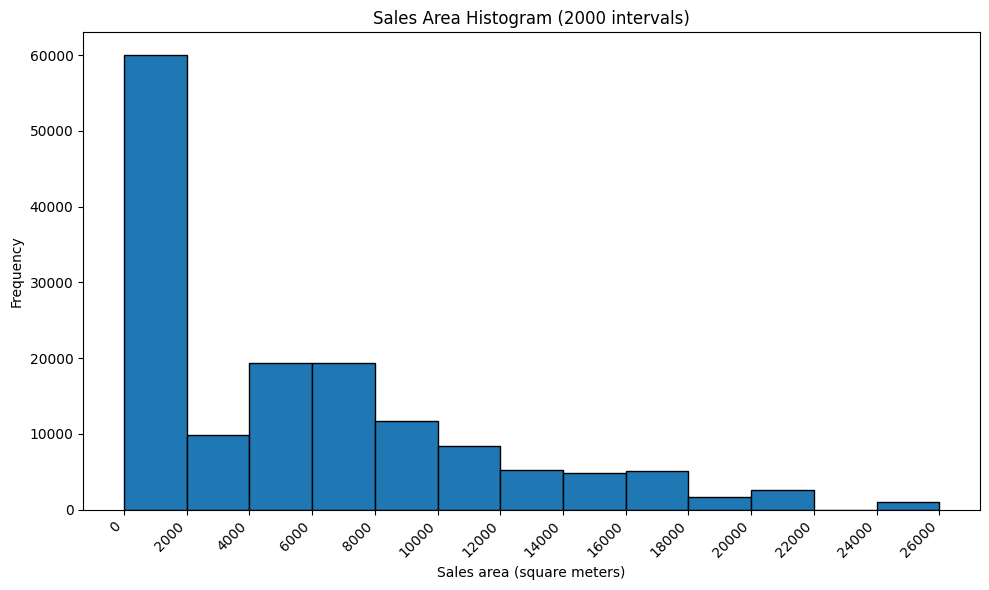

Ranges (bins): [    0.  2000.  4000.  6000.  8000. 10000. 12000. 14000. 16000. 18000.
 20000. 22000. 24000. 26000.]
0.0 - 2000.0
2000.0 - 4000.0
4000.0 - 6000.0
6000.0 - 8000.0
8000.0 - 10000.0
10000.0 - 12000.0
12000.0 - 14000.0
14000.0 - 16000.0
16000.0 - 18000.0
18000.0 - 20000.0
20000.0 - 22000.0
22000.0 - 24000.0
24000.0 - 26000.0


In [38]:
# Sets the intervals from 2000 to 2000
bins = range(0, df_merged['selling_square_ft'].max() + 2000, 2000)

plt.figure(figsize=(10, 6)) # Set the size of the figure

# Creates the histogram and gets the interval values
counts, bins, _ = plt.hist(df_merged['selling_square_ft'], bins=bins, edgecolor='black')

plt.xlabel('Sales area (square meters)')
plt.ylabel('Frequency')
plt.title('Sales Area Histogram (2000 intervals)')

plt.xticks(bins) 
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Print the list of intervals
print('Ranges (bins):', bins)

# For a better visualization of the ranges, we can iterate over them
for i in range(len(bins) - 1):
    print(f'{bins[i]} - {bins[i+1]}')

### variable sales_area_interval

In [39]:
def selling_square_interval (value):
  if pd.isna(value):
    return "no profit"
  elif value < 2000:
    return "[0 - 2000["
  elif value < 4000:
    return "[2000 - 4000["
  elif value < 6000:
    return "[4000 - 6000["
  elif value < 8000:
    return "[6000 - 8000["
  elif value < 10000:
    return "[8000 - 10000["
  elif value < 12000:
    return "[10000 - 12000["
  elif value < 14000:
    return "[12000 - 14000["
  elif value >= 14000:
    return "[14000 - ]"
  else:
    return "other"

# Applies the function to the column 'profit (€)' and creates the new column 'profit_interval'
df_merged['selling_square_interval'] = df_merged['selling_square_ft'].apply(selling_square_interval)

df_merged.head()

,idstore,district,region,selling_square_ft,type,sku,brand,marca,oldpvp,new_pvp,...,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%,discount_plus_5%,average_shelf_life_3days_prev,selling_square_interval
0,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.22,2.11,...,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[
1,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,3.96,1.98,...,NaT,199,NaN,1,False,0.0,0.6,0.55,0.0,[4000 - 6000[
2,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.74,2.37,...,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[
3,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.20,2.10,...,2021-10-02,199,1.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[
4,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.62,2.31,...,2021-10-03,199,2.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[


# Coding of variables

## Coding of the payment_method variable

In [40]:
data=df_merged

# Create ‘card’ and ‘cash’ columns based on ‘payment_method’
data['card'] = data['payment_method'].apply(lambda x: 1 if x == 'card' else 0)
data['cash'] = data['payment_method'].apply(lambda x: 1 if x == 'cash' else 0)

data.head()


,idstore,district,region,selling_square_ft,type,sku,brand,marca,oldpvp,new_pvp,...,period_sell_vs_labelling,period_expiring_vs_labelling,sold,average_profit_3days_sku,discount_plus_10%,discount_plus_5%,average_shelf_life_3days_prev,selling_square_interval,card,cash
0,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.22,2.11,...,1.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[,1,0
1,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,3.96,1.98,...,NaN,1,False,0.0,0.6,0.55,0.0,[4000 - 6000[,0,0
2,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.74,2.37,...,2.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[,0,1
3,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.20,2.10,...,1.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[,1,0
4,1,Évora,Southern Region,4762,Large,1,marca1,outras marcas,4.62,2.31,...,2.0,2,True,0.0,0.6,0.55,0.0,[4000 - 6000[,0,1


## Coding of district variable

In [41]:
# Copy of the district variable for hot encoding
data = data.assign(district_copy=data['district'])

# One Hot Encoding district variable
data = pd.get_dummies(data, columns=['district'], prefix=['district'])
data.head()

,idstore,region,selling_square_ft,type,sku,brand,marca,oldpvp,new_pvp,discount,...,district_Leiria,district_Lisboa,district_Portalegre,district_Porto,district_Santarém,district_Setúbal,district_Viana do Castelo,district_Vila Real,district_Viseu,district_Évora
0,1,Southern Region,4762,Large,1,marca1,outras marcas,4.22,2.11,0.5,...,False,False,False,False,False,False,False,False,False,True
1,1,Southern Region,4762,Large,1,marca1,outras marcas,3.96,1.98,0.5,...,False,False,False,False,False,False,False,False,False,True
2,1,Southern Region,4762,Large,1,marca1,outras marcas,4.74,2.37,0.5,...,False,False,False,False,False,False,False,False,False,True
3,1,Southern Region,4762,Large,1,marca1,outras marcas,4.20,2.10,0.5,...,False,False,False,False,False,False,False,False,False,True
4,1,Southern Region,4762,Large,1,marca1,outras marcas,4.62,2.31,0.5,...,False,False,False,False,False,False,False,False,False,True


In [42]:
# Variables with prefix 'district'
district_columns = [col for col in data.columns if 'district' in col]
print("Variables with prefix 'district:")
print(district_columns)

Variables with prefix 'district:
['district_copy', 'district_Aveiro', 'district_Beja', 'district_Braga', 'district_Bragança', 'district_Castelo Branco', 'district_Coimbra', 'district_Faro', 'district_Guarda', 'district_Leiria', 'district_Lisboa', 'district_Portalegre', 'district_Porto', 'district_Santarém', 'district_Setúbal', 'district_Viana do Castelo', 'district_Vila Real', 'district_Viseu', 'district_Évora']


## Coding of type variable

In [43]:
# One Hot Encoding type variable
data = pd.get_dummies(data, columns=['type'], prefix=['type'])
data.head()

,idstore,region,selling_square_ft,sku,brand,marca,oldpvp,new_pvp,discount,discount%interval,...,district_Porto,district_Santarém,district_Setúbal,district_Viana do Castelo,district_Vila Real,district_Viseu,district_Évora,type_Large,type_Medium,type_Small
0,1,Southern Region,4762,1,marca1,outras marcas,4.22,2.11,0.5,[40 - 60%[,...,False,False,False,False,False,False,True,True,False,False
1,1,Southern Region,4762,1,marca1,outras marcas,3.96,1.98,0.5,[40 - 60%[,...,False,False,False,False,False,False,True,True,False,False
2,1,Southern Region,4762,1,marca1,outras marcas,4.74,2.37,0.5,[40 - 60%[,...,False,False,False,False,False,False,True,True,False,False
3,1,Southern Region,4762,1,marca1,outras marcas,4.20,2.10,0.5,[40 - 60%[,...,False,False,False,False,False,False,True,True,False,False
4,1,Southern Region,4762,1,marca1,outras marcas,4.62,2.31,0.5,[40 - 60%[,...,False,False,False,False,False,False,True,True,False,False


In [44]:
# Variables with prefix 'type'
type_columns = [col for col in data.columns if 'type' in col]
print("Variables with prefix 'type':")
print(type_columns)


Variables with prefix 'type':
['type_Large', 'type_Medium', 'type_Small']


## Coding of variable region

In [45]:
# One Hot Encoding region variable
data = pd.get_dummies(data, columns=['region'])
data.head()

,idstore,selling_square_ft,sku,brand,marca,oldpvp,new_pvp,discount,discount%interval,labelqty,...,district_Évora,type_Large,type_Medium,type_Small,region_Central Region,region_Lisbon,region_Northern Region,region_Porto,region_South Region,region_Southern Region
0,1,4762,1,marca1,outras marcas,4.22,2.11,0.5,[40 - 60%[,1,...,True,True,False,False,False,False,False,False,False,True
1,1,4762,1,marca1,outras marcas,3.96,1.98,0.5,[40 - 60%[,1,...,True,True,False,False,False,False,False,False,False,True
2,1,4762,1,marca1,outras marcas,4.74,2.37,0.5,[40 - 60%[,1,...,True,True,False,False,False,False,False,False,False,True
3,1,4762,1,marca1,outras marcas,4.20,2.10,0.5,[40 - 60%[,1,...,True,True,False,False,False,False,False,False,False,True
4,1,4762,1,marca1,outras marcas,4.62,2.31,0.5,[40 - 60%[,1,...,True,True,False,False,False,False,False,False,False,True


## Coding of weekday variable

In [46]:
# One Hot Encoding weekday variable
data = pd.get_dummies(data, columns=['weekday'])
data.head()

,idstore,selling_square_ft,sku,brand,marca,oldpvp,new_pvp,discount,discount%interval,labelqty,...,region_Porto,region_South Region,region_Southern Region,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1,4762,1,marca1,outras marcas,4.22,2.11,0.5,[40 - 60%[,1,...,False,False,True,True,False,False,False,False,False,False
1,1,4762,1,marca1,outras marcas,3.96,1.98,0.5,[40 - 60%[,1,...,False,False,True,True,False,False,False,False,False,False
2,1,4762,1,marca1,outras marcas,4.74,2.37,0.5,[40 - 60%[,1,...,False,False,True,True,False,False,False,False,False,False
3,1,4762,1,marca1,outras marcas,4.20,2.10,0.5,[40 - 60%[,1,...,False,False,True,True,False,False,False,False,False,False
4,1,4762,1,marca1,outras marcas,4.62,2.31,0.5,[40 - 60%[,1,...,False,False,True,True,False,False,False,False,False,False


## Coding of marca variable

In [47]:
# One Hot Encoding brand variable
data = pd.get_dummies(data, columns=['marca'], prefix='brand')
data.head()

,idstore,selling_square_ft,sku,brand,oldpvp,new_pvp,discount,discount%interval,labelqty,weight (g),...,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,brand_marca15,brand_marca2,brand_marca7,brand_outras marcas
0,1,4762,1,marca1,4.22,2.11,0.5,[40 - 60%[,1,260.0,...,False,False,False,False,False,False,False,False,False,True
1,1,4762,1,marca1,3.96,1.98,0.5,[40 - 60%[,1,260.0,...,False,False,False,False,False,False,False,False,False,True
2,1,4762,1,marca1,4.74,2.37,0.5,[40 - 60%[,1,260.0,...,False,False,False,False,False,False,False,False,False,True
3,1,4762,1,marca1,4.20,2.10,0.5,[40 - 60%[,1,260.0,...,False,False,False,False,False,False,False,False,False,True
4,1,4762,1,marca1,4.62,2.31,0.5,[40 - 60%[,1,260.0,...,False,False,False,False,False,False,False,False,False,True


## Coding of variable selling_square_interval

In [48]:
data = pd.get_dummies(data, columns=['selling_square_interval'], prefix='selling_square_interval ')

data.head()

,idstore,selling_square_ft,sku,brand,oldpvp,new_pvp,discount,discount%interval,labelqty,weight (g),...,brand_marca7,brand_outras marcas,selling_square_interval _[0 - 2000[,selling_square_interval _[10000 - 12000[,selling_square_interval _[12000 - 14000[,selling_square_interval _[14000 - ],selling_square_interval _[2000 - 4000[,selling_square_interval _[4000 - 6000[,selling_square_interval _[6000 - 8000[,selling_square_interval _[8000 - 10000[
0,1,4762,1,marca1,4.22,2.11,0.5,[40 - 60%[,1,260.0,...,False,True,False,False,False,False,False,True,False,False
1,1,4762,1,marca1,3.96,1.98,0.5,[40 - 60%[,1,260.0,...,False,True,False,False,False,False,False,True,False,False
2,1,4762,1,marca1,4.74,2.37,0.5,[40 - 60%[,1,260.0,...,False,True,False,False,False,False,False,True,False,False
3,1,4762,1,marca1,4.20,2.10,0.5,[40 - 60%[,1,260.0,...,False,True,False,False,False,False,False,True,False,False
4,1,4762,1,marca1,4.62,2.31,0.5,[40 - 60%[,1,260.0,...,False,True,False,False,False,False,False,True,False,False


# Removal of features and *missing values* in the variable weight

In [49]:
columnsto_drop=['brand','labelqty','payment_method','sell_date','discount%interval','margin%interval',
                'perc_interval','expiring_date','labelling_date','period_sell_vs_labelling']

data = data.dropna(subset=['weight (g)']).drop(columns=columnsto_drop)
data.head()

,idstore,selling_square_ft,sku,oldpvp,new_pvp,discount,weight (g),margin (%),expected_profit,perc_expiring_sku,...,brand_marca7,brand_outras marcas,selling_square_interval _[0 - 2000[,selling_square_interval _[10000 - 12000[,selling_square_interval _[12000 - 14000[,selling_square_interval _[14000 - ],selling_square_interval _[2000 - 4000[,selling_square_interval _[4000 - 6000[,selling_square_interval _[6000 - 8000[,selling_square_interval _[8000 - 10000[
0,1,4762,1,4.22,2.11,0.5,260.0,16,0.3376,0.010050,...,False,True,False,False,False,False,False,True,False,False
1,1,4762,1,3.96,1.98,0.5,260.0,16,0.3168,0.005025,...,False,True,False,False,False,False,False,True,False,False
2,1,4762,1,4.74,2.37,0.5,260.0,16,0.3792,0.010050,...,False,True,False,False,False,False,False,True,False,False
3,1,4762,1,4.20,2.10,0.5,260.0,16,0.3360,0.010050,...,False,True,False,False,False,False,False,True,False,False
4,1,4762,1,4.62,2.31,0.5,260.0,16,0.3696,0.010050,...,False,True,False,False,False,False,False,True,False,False


# Correlation Matrix

In [50]:
# Change the data type of the ‘card’ column to boolean
data['card'] = data['card'].astype(bool)

# Change the data type of the 'cash' column to boolean
data['cash'] = data['cash'].astype(bool)

data.head()

,idstore,selling_square_ft,sku,oldpvp,new_pvp,discount,weight (g),margin (%),expected_profit,perc_expiring_sku,...,brand_marca7,brand_outras marcas,selling_square_interval _[0 - 2000[,selling_square_interval _[10000 - 12000[,selling_square_interval _[12000 - 14000[,selling_square_interval _[14000 - ],selling_square_interval _[2000 - 4000[,selling_square_interval _[4000 - 6000[,selling_square_interval _[6000 - 8000[,selling_square_interval _[8000 - 10000[
0,1,4762,1,4.22,2.11,0.5,260.0,16,0.3376,0.010050,...,False,True,False,False,False,False,False,True,False,False
1,1,4762,1,3.96,1.98,0.5,260.0,16,0.3168,0.005025,...,False,True,False,False,False,False,False,True,False,False
2,1,4762,1,4.74,2.37,0.5,260.0,16,0.3792,0.010050,...,False,True,False,False,False,False,False,True,False,False
3,1,4762,1,4.20,2.10,0.5,260.0,16,0.3360,0.010050,...,False,True,False,False,False,False,False,True,False,False
4,1,4762,1,4.62,2.31,0.5,260.0,16,0.3696,0.010050,...,False,True,False,False,False,False,False,True,False,False


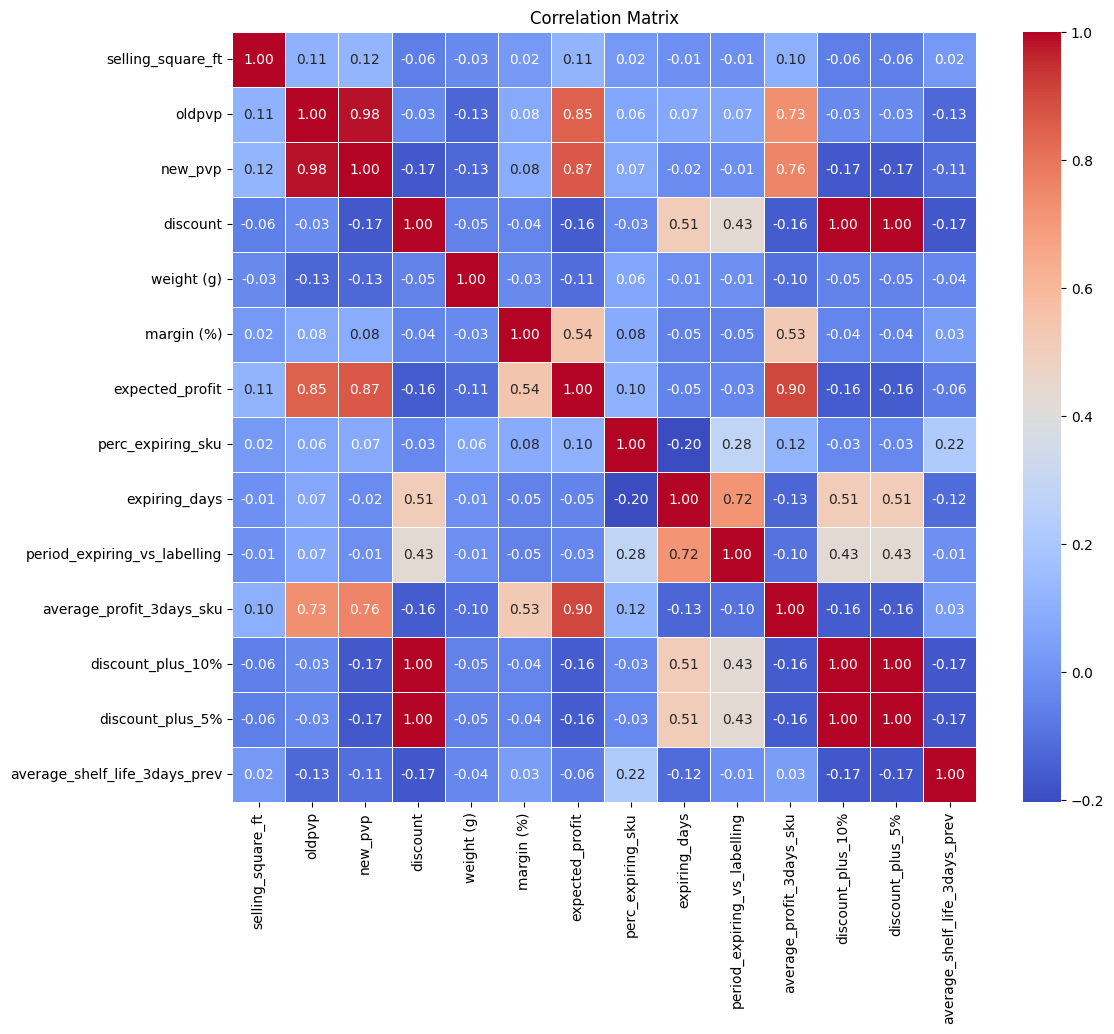

In [70]:
# Creates a correlation matrix with numeric variables and the variable ‘sold’, excluding ‘idstore’.
data_copy = data

def correlation_matrix_sold(data_copy):
    # Remove the ‘idstore’ columns
    data_copy = data_copy.drop(columns=['idstore','sku'], errors='ignore')

    # Select the numeric columns and the ‘sold’ column
    num_variables = data_copy.select_dtypes(include=['number']).columns.tolist()
    selected_variables = num_variables
    selected_data = data_copy[selected_variables]

    # Calculate the correlation matrix
    correlation_matrix = selected_data.corr()

    return correlation_matrix

# Assuming that ‘data_copy’ is your DataFrame
correlation_matrix = correlation_matrix_sold(data_copy)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# Creating the dataset for the model

In [52]:
correlations = correlation_matrix

# Extract the correlations from the upper diagonal (without duplicates and excluding the main diagonal)
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))

# Stacks the correlations in a series format
stacked = upper.stack()

# Sort the correlations in descending order
sorted_correlations = stacked.sort_values(ascending=False)

# Filters out correlations with an absolute value greater than 0.5
high_correlations = sorted_correlations[abs(sorted_correlations) > 0.5]

# Display the correlations
print(high_correlations)

discount           discount_plus_5%                1.000000
discount_plus_10%  discount_plus_5%                1.000000
discount           discount_plus_10%               1.000000
oldpvp             new_pvp                         0.984904
expected_profit    average_profit_3days_sku        0.904568
new_pvp            expected_profit                 0.865854
oldpvp             expected_profit                 0.847806
new_pvp            average_profit_3days_sku        0.757795
oldpvp             average_profit_3days_sku        0.730365
expiring_days      period_expiring_vs_labelling    0.715247
margin (%)         expected_profit                 0.544774
                   average_profit_3days_sku        0.526811
discount           expiring_days                   0.511426
expiring_days      discount_plus_5%                0.511426
                   discount_plus_10%               0.511426
dtype: float64


In [53]:
data.head()

,idstore,selling_square_ft,sku,oldpvp,new_pvp,discount,weight (g),margin (%),expected_profit,perc_expiring_sku,...,brand_marca7,brand_outras marcas,selling_square_interval _[0 - 2000[,selling_square_interval _[10000 - 12000[,selling_square_interval _[12000 - 14000[,selling_square_interval _[14000 - ],selling_square_interval _[2000 - 4000[,selling_square_interval _[4000 - 6000[,selling_square_interval _[6000 - 8000[,selling_square_interval _[8000 - 10000[
0,1,4762,1,4.22,2.11,0.5,260.0,16,0.3376,0.010050,...,False,True,False,False,False,False,False,True,False,False
1,1,4762,1,3.96,1.98,0.5,260.0,16,0.3168,0.005025,...,False,True,False,False,False,False,False,True,False,False
2,1,4762,1,4.74,2.37,0.5,260.0,16,0.3792,0.010050,...,False,True,False,False,False,False,False,True,False,False
3,1,4762,1,4.20,2.10,0.5,260.0,16,0.3360,0.010050,...,False,True,False,False,False,False,False,True,False,False
4,1,4762,1,4.62,2.31,0.5,260.0,16,0.3696,0.010050,...,False,True,False,False,False,False,False,True,False,False


In [54]:
# Create a new DataFrame with the selected columns
model_dataset = data[['perc_expiring_sku', 'new_pvp', 'selling_square_ft', 'average_profit_3days_sku', 'average_shelf_life_3days_prev',
                            'sold']]

model_dataset.head()

,perc_expiring_sku,new_pvp,selling_square_ft,average_profit_3days_sku,average_shelf_life_3days_prev,sold
0,0.010050,2.11,4762,0.0,0.0,True
1,0.005025,1.98,4762,0.0,0.0,False
2,0.010050,2.37,4762,0.0,0.0,True
3,0.010050,2.10,4762,0.0,0.0,True
4,0.010050,2.31,4762,0.0,0.0,True


In [55]:
# Move the ‘sold’ column to the last position
cols = list(model_dataset.columns)
cols.remove('sold')
cols.append('sold')
model_dataset = model_dataset[cols]

model_dataset.head()

,perc_expiring_sku,new_pvp,selling_square_ft,average_profit_3days_sku,average_shelf_life_3days_prev,sold
0,0.010050,2.11,4762,0.0,0.0,True
1,0.005025,1.98,4762,0.0,0.0,False
2,0.010050,2.37,4762,0.0,0.0,True
3,0.010050,2.10,4762,0.0,0.0,True
4,0.010050,2.31,4762,0.0,0.0,True


In [56]:
# Show rows with null values in ‘model_dataset’
print(model_dataset[model_dataset.isnull().any(axis=1)])


Empty DataFrame
Columns: [perc_expiring_sku, new_pvp, selling_square_ft, average_profit_3days_sku, average_shelf_life_3days_prev, sold]
Index: []


In [57]:
X = model_dataset.iloc[:, :-1].values
y = model_dataset.iloc[:, -1].values

# Removal of outliers

In [58]:
# Removes outliers from specific columns using the IQR method.

def remove_outliers_iqr(df, columns):
    df_without_outliers = df.copy()
    outliers_removed = {}

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 5 * IQR
        upper_limit = Q3 + 5 * IQR

        outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
        outliers_removed[column] = len(outliers)

        df_without_outliers = df_without_outliers[(df_without_outliers[column] >= lower_limit) & (df_without_outliers[column] <= upper_limit)]

    return df_without_outliers, outliers_removed

columns_for_removing_outliers = ['new_pvp']
model_dataset_without_outliers, count_outliers = remove_outliers_iqr(model_dataset, columns_for_removing_outliers)
model_dataset = model_dataset_without_outliers

print('DataFrame model_dataset without outliers:')
model_dataset_without_outliers.head()

print('\nCount of outliers removed:')
print(count_outliers)

DataFrame model_dataset without outliers:

Count of outliers removed:
{'new_pvp': 13}


# Stratified Split

In [59]:
# Set the size of the test set
test_size = 0.2

# Set the random state to ensure reproducibility
random_state = 42

# Perform the stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=random_state
)

In [60]:
X_train

array([[2.00000000e-01, 9.00000000e-01, 5.22300000e+03, 9.91399459e-02,
        6.61671896e-01],
       [2.50000000e-01, 1.11000000e+00, 1.32900000e+03, 1.66500000e-01,
        0.00000000e+00],
       [6.66666667e-01, 1.18000000e+00, 1.20090000e+04, 2.36880053e-01,
        1.60373760e+00],
       ...,
       [3.36134454e-02, 9.90000000e-01, 6.44600000e+03, 1.28700000e-01,
        0.00000000e+00],
       [0.00000000e+00, 8.30000000e-01, 2.46900000e+03, 1.66703315e-01,
        7.44408394e-01],
       [5.30303030e-02, 1.24000000e+00, 1.23580000e+04, 2.89333333e-01,
        0.00000000e+00]])

In [61]:
X_test

array([[2.00000000e-01, 1.49000000e+00, 5.04800000e+03, 1.53151173e-01,
        8.77925259e-01],
       [3.33333333e-01, 1.04000000e+00, 5.22300000e+03, 1.77977238e-01,
        1.27447041e+00],
       [6.66666667e-01, 1.04000000e+00, 8.32900000e+03, 1.76800000e-01,
        0.00000000e+00],
       ...,
       [0.00000000e+00, 1.32000000e+00, 1.67700000e+03, 2.11915840e-01,
        8.61659650e-01],
       [0.00000000e+00, 8.30000000e-01, 1.89900000e+03, 1.67597678e-01,
        1.90744201e+00],
       [3.33333333e-01, 1.74000000e+00, 1.14720000e+04, 2.95800000e-01,
        1.87699531e+00]])

In [62]:
y_train

array([ True, False, False, ..., False,  True,  True])

In [63]:
y_test

array([ True, False,  True, ..., False, False, False])

## Distribution of datasets y_train and y_test by target variable

### Distribution of the target variable in the y_train dataset

Type of y_train before conversion: <class 'numpy.ndarray'>
Type of y_train after conversion: <class 'pandas.core.frame.DataFrame'>


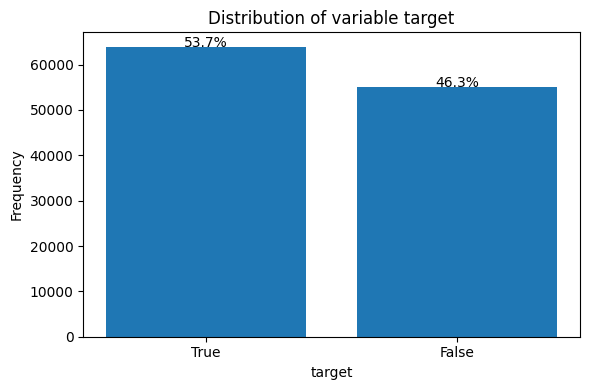

In [64]:
# Check the type of y_train
print(f'Type of y_train before conversion: {type(y_train)}')

if isinstance(y_train, np.ndarray):
    # If it's a NumPy array, convert to DataFrame
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1) # Reshape to a column
    y_train = pd.DataFrame(y_train, columns=['target']) # Name the column ‘target’
    print(f'Type of y_train after conversion: {type(y_train)}')
else:
    print('y_train is already a DataFrame.')

# Analysing the distribution
try:
    variable = 'target'
    distribution = y_train[variable].value_counts()

    # Calculating percentages
    total = len(y_train)
    percentage_true = (distribution[True] / total) * 100 if True in distribution else 0
    percentage_false = (distribution[False] / total) * 100 if False in distribution else 0

    # Creating the graph
    plt.figure(figsize=(6, 4))
    plt.bar(['True', 'False'], [distribution.get(True, 0), distribution.get(False, 0)])
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title('Distribution of variable ' + variable + '')

    # Add extra information
    plt.text(0, distribution.get(True, 0) + 10, f'{percentage_true:.1f}%', ha='center') # Percentage of True
    plt.text(1, distribution.get(False, 0) + 10, f'{percentage_false:.1f}%', ha='center') # Percentage of False

    plt.tight_layout()
    plt.show()

except KeyError:
    print(f"Error: Column '{variable}' not found in DataFrame y_train.")
    print(f'Existing columns: {y_train.columns}')
    exit()

### Distribution of the target variable in the y_test dataset

Type of y_train before conversion: <class 'pandas.core.frame.DataFrame'>
y_train is already a DataFrame.


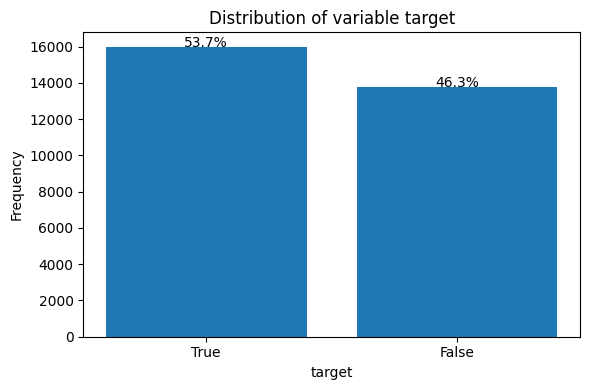

In [69]:
# Check the type of y_train
print(f'Type of y_train before conversion: {type(y_test)}')

if isinstance(y_test, np.ndarray):
    # If it's a NumPy array, convert to DataFrame
    if y_test.ndim == 1:
        y_test = y_test.reshape(-1, 1) # Reshape to a column
    y_test = pd.DataFrame(y_test, columns=['target']) # Name the column ‘target’
    print(f'Type of y_train after conversion: {type(y_test)}')
else:
    print('y_train is already a DataFrame.')

# Analysing the distribution
try:
    variavel = 'target' # Or the name of your variable
    distribution = y_test[variable].value_counts()

    # Calculating percentages
    total = len(y_test)
    percentage_true = (distribution[True] / total) * 100 if True in distribution else 0
    percentage_false = (distribution[False] / total) * 100 if False in distribution else 0

    plt.figure(figsize=(6, 4))
    bars = plt.bar(['True', 'False'], [distribution.get(True, 0), distribution.get(False, 0)])
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f"Distribution of variable target")

    # Add extra information
    plt.text(0, distribution.get(True, 0) + 10, f'{percentage_true:.1f}%', ha='center') # Percentage of True
    plt.text(1, distribution.get(False, 0) + 10, f'{percentage_false:.1f}%', ha='center') # Percentage of False

    plt.tight_layout()
    plt.show()

except KeyError:
    print(f'Error: Column “{variable}” not found in DataFrame y_train.')
    print(f'Existing columns: {y_test.columns}')
    exit()

# Feature scaling

In [311]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [312]:
print(X_train)

[[-0.83053505 -0.49493551 -0.0865195  -0.89270916 -0.69831893]
 [-0.60605279  0.03765013 -0.79999748 -0.03912621 -1.66693868]
 [ 1.26463263  0.21517868  1.15684506  0.85272601  0.68076859]
 ...
 [-1.57755161 -0.26668452  0.13756463 -0.51812576 -1.66693868]
 [-1.72846405 -0.67246406 -0.59112103 -0.03654982 -0.57720118]
 [-1.49037681  0.36734601  1.22079057  1.51741113 -1.66693868]]


In [313]:
print(X_test)

[[-0.83053505  1.00137654 -0.11858386 -0.20828181 -0.3817462 ]
 [-0.23191571 -0.13987842 -0.0865195   0.10631273  0.19875522]
 [ 1.26463263 -0.13987842  0.48257722  0.09139483 -1.66693868]
 ...
 [-1.72846405  0.57023578 -0.73623519  0.53638085 -0.40555738]
 [-1.72846405 -0.67246406 -0.69555925 -0.02521649  1.12536067]
 [-0.23191571  1.63540708  1.05845326  1.59935638  1.08078983]]


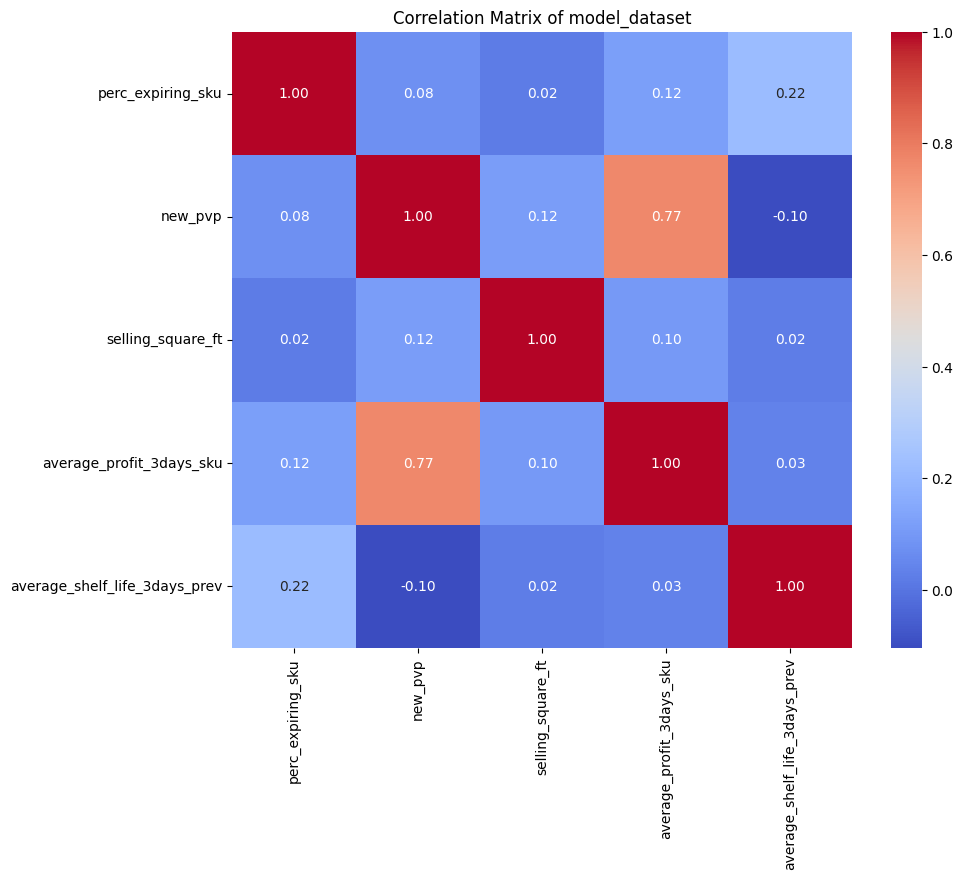

In [314]:
# Calculate the correlation matrix for the model_dataset

model_corr = model_dataset
correlation_matrix = model_corr.drop(columns='sold').corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of model_dataset')
plt.show()


# Predictive modelling

## Import libraries for modelling

In [315]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB

## Training the Logistic Regression model

In [316]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

c:\Users\macn1\Documents\EDITDSBA\10_Projeto_Final\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [317]:
y_pred = classifier.predict(X_test)

y_pred_np = y_pred.reshape(len(y_pred), 1)
y_test_np = y_test.values.reshape(len(y_test), 1)

print(np.concatenate((y_pred_np, y_test_np), 1))

[[False  True]
 [ True False]
 [ True  True]
 ...
 [False False]
 [False False]
 [False False]]


In [318]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 4524  9254]
 [ 3299 12683]]


0.5781922043010753

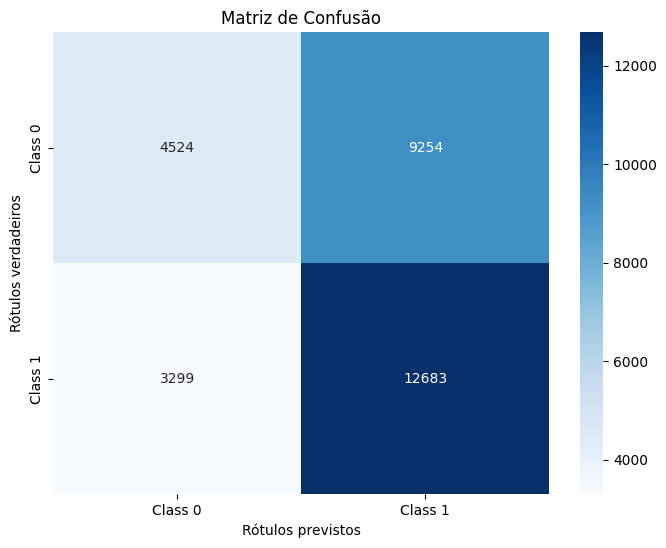

     Class  Precision   Recall  F1 Score
0  Class 0   0.578295  0.32835  0.418869
1  Class 1   0.578156  0.79358  0.668952
Overall Accuracy: 0.58


In [319]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Rótulos previstos')
plt.ylabel('Rótulos verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

# Calculate the precision, recovery, F1 score and accuracy for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Display the metrics
metrics = {
    "Class": ["Class 0", "Class 1"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}


metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Display overall accuracy
print(f"Overall Accuracy: {accuracy:.2f}")

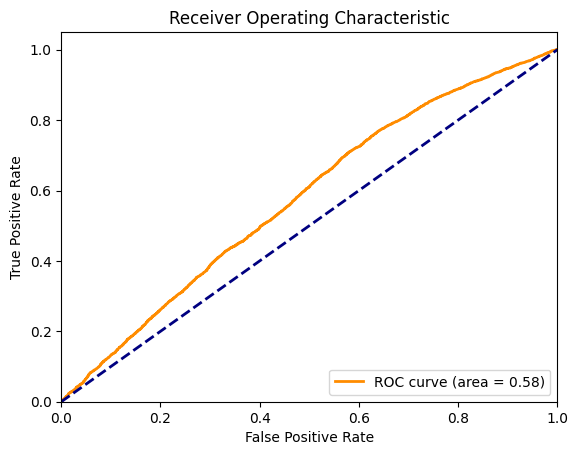

In [320]:
# Get predicted probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Naive Bayes

In [321]:
alpha_value = 1
binarize_value = 0

classifier = BernoulliNB(alpha=alpha_value, binarize=binarize_value)

# Train the model using the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}\n')
print('Confusion Matrix:')
print(conf_matrix, '\n')
print('Classification Report:')
print(class_report)

Accuracy: 0.5533602150537634

Confusion Matrix:
[[6951 6827]
 [6465 9517]] 

Classification Report:
              precision    recall  f1-score   support

       False       0.52      0.50      0.51     13778
        True       0.58      0.60      0.59     15982

    accuracy                           0.55     29760
   macro avg       0.55      0.55      0.55     29760
weighted avg       0.55      0.55      0.55     29760



c:\Users\macn1\Documents\EDITDSBA\10_Projeto_Final\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [322]:
cm = confusion_matrix(y_test, y_pred)

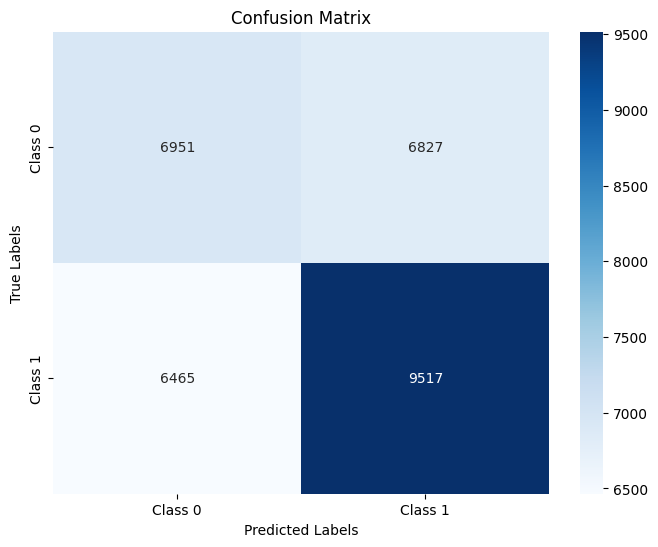

     Class  Precision    Recall  F1 Score
0  Class 0   0.518113  0.504500  0.511216
1  Class 1   0.582293  0.595482  0.588814

Accuracy: 0.5533602150537634


In [323]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the precision, recovery, F1 score and accuracy for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Display the metrics
metrics = {
    "Class": ["Class 0", "Class 1"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

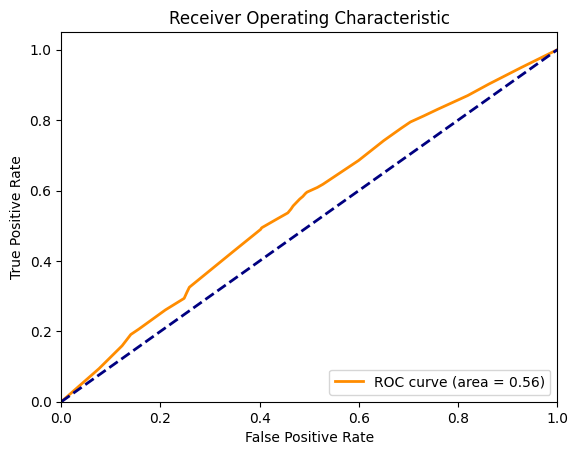

In [324]:
# Obter probabilidades previstas para a classe positiva
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e a AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Training the Decision Tree Regression model

In [325]:
classifier = DecisionTreeClassifier(max_depth = 20, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)

In [326]:
y_pred = classifier.predict(X_test)

y_pred_np = y_pred.reshape(len(y_pred), 1)
y_test_np = y_test.values.reshape(len(y_test), 1)

print(np.concatenate((y_pred_np, y_test_np), 1))

[[False  True]
 [ True False]
 [ True  True]
 ...
 [False False]
 [False False]
 [False False]]


In [327]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 9473  4305]
 [ 4497 11485]]


0.7042338709677419

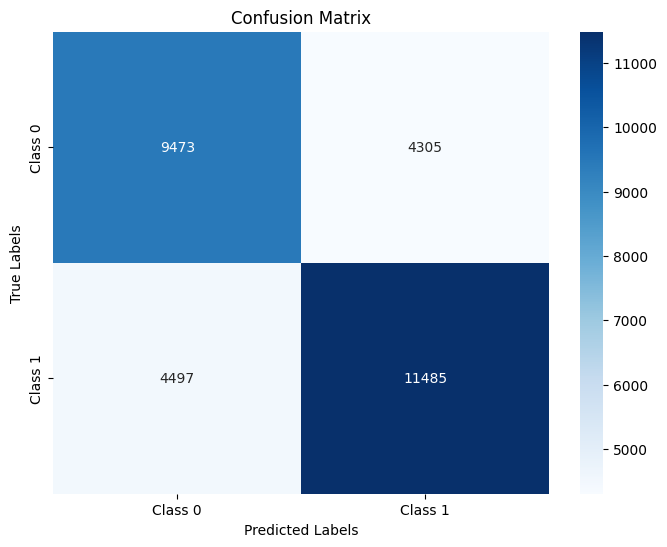

     Class  Precision    Recall  F1 Score
0  Class 0   0.678096  0.687545  0.682788
1  Class 1   0.727359  0.718621  0.722964

Accuracy: 0.7042338709677419


In [328]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the precision, recovery, F1 score and accuracy for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Display the metrics
metrics = {
    "Class": ["Class 0", "Class 1"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

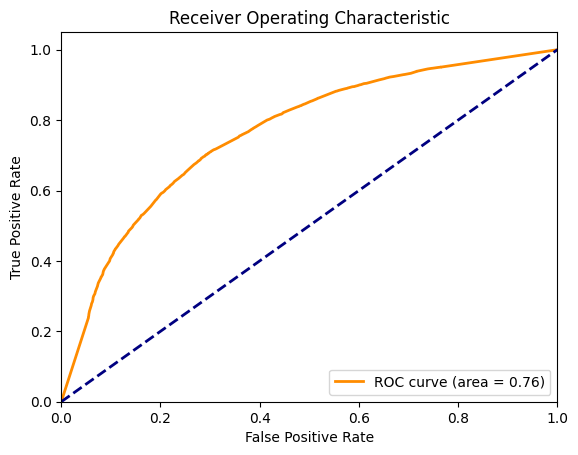

In [329]:
# Obtain predicted probabilities for the positive class

y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Training the Random Forest Regression model

In [334]:
classifier = RandomForestClassifier(n_estimators = 10, random_state = 0)
classifier.fit(X_train, y_train)

c:\Users\macn1\Documents\EDITDSBA\10_Projeto_Final\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=10, random_state=0)

In [335]:
y_pred = classifier.predict(X_test)

y_pred_np = y_pred.reshape(len(y_pred), 1)
y_test_np = y_test.values.reshape(len(y_test), 1)

print(np.concatenate((y_pred_np, y_test_np), 1))

[[ True  True]
 [ True False]
 [ True  True]
 ...
 [False False]
 [False False]
 [ True False]]


In [336]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 9722  4056]
 [ 4183 11799]]


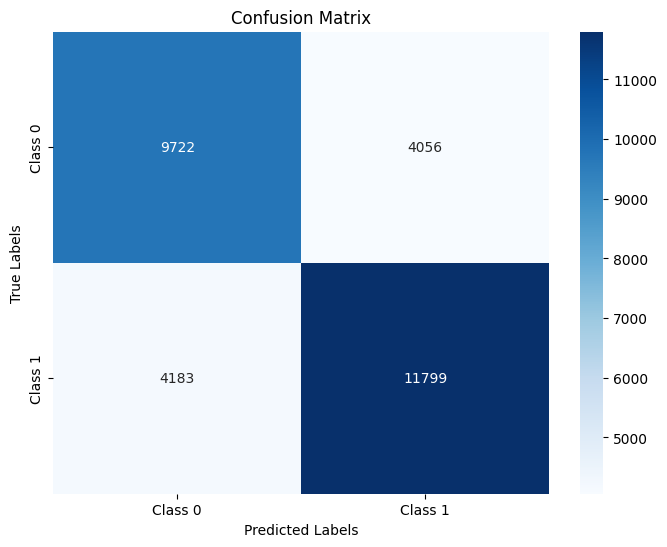

     Class  Precision    Recall  F1 Score
0  Class 0   0.699173  0.705618  0.702381
1  Class 1   0.744182  0.738268  0.741213

Accuracy: 0.7231518817204301


In [337]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the precision, recovery, F1 score and accuracy for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Display the metrics
metrics = {
    "Class": ["Class 0", "Class 1"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")


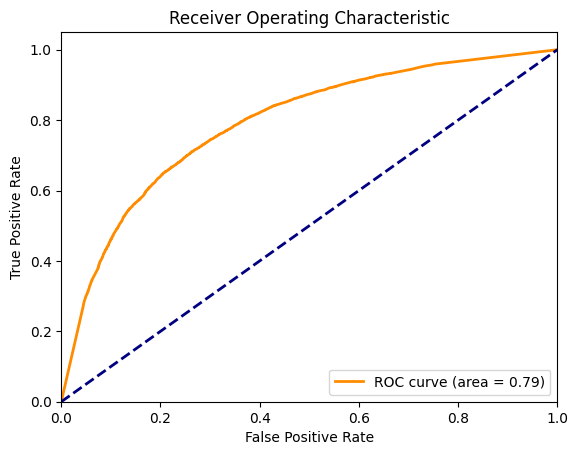

In [338]:
# Obtain predicted probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Grid-Search

In [ ]:
# Define the grid of parameters to be searched
param_grid = {
    'n_estimators': [50, 100, 200, 400], # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'criterion': ['gini'] #Function to measure the quality of a split;
}

# Generate the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42) # Setting a random state ensures consistent results

# Generate GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2) # cv=5 for 5-fold cross-validation, n_jobs=-1 uses all available cores, verbose prints progress

# Adjust the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model to make predictions on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Best Score: 0.7206330284820675
              precision    recall  f1-score   support

       False       0.71      0.71      0.71     13778
        True       0.75      0.75      0.75     15982

    accuracy                           0.73     29760
   macro avg       0.73      0.73      0.73     29760
weighted avg       0.73      0.73      0.73     29760

Test Accuracy: 0.7310147849462365


## RandomForest model after parameter tunning

In [339]:
classifier = RandomForestClassifier(
    n_estimators=400, 
    criterion='gini', 
    max_depth=None, 
    min_samples_split=5, 
    min_samples_leaf=1, 
    random_state=42
)
classifier.fit(X_train, y_train)

c:\Users\macn1\Documents\EDITDSBA\10_Projeto_Final\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=5, n_estimators=400, random_state=42)

In [340]:
y_pred = classifier.predict(X_test)

y_pred_np = y_pred.reshape(len(y_pred), 1)
y_test_np = y_test.values.reshape(len(y_test), 1)

print(np.concatenate((y_pred_np, y_test_np), 1))

[[ True  True]
 [ True False]
 [ True  True]
 ...
 [False False]
 [False False]
 [ True False]]


In [341]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 9718  4060]
 [ 3962 12020]]


### Matriz de confusão

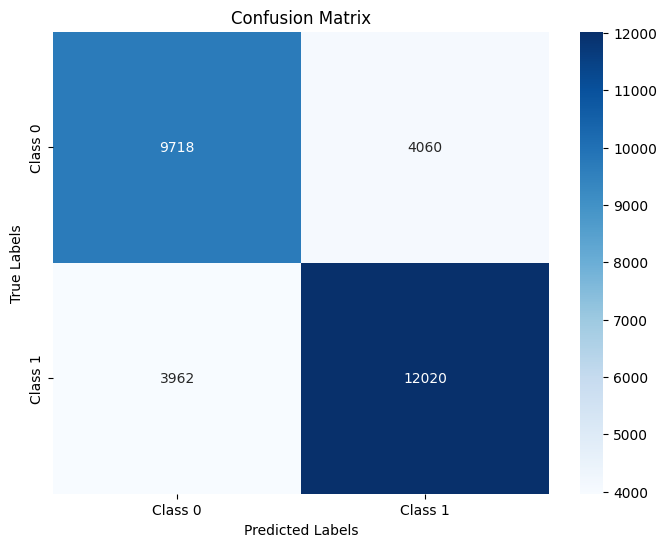

     Class  Precision    Recall  F1 Score
0  Class 0   0.710380  0.705327  0.707845
1  Class 1   0.747512  0.752096  0.749797

Accuracy: 0.7304435483870968


In [342]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the precision, recovery, F1 score and accuracy for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Display the metrics
metrics = {
    "Class": ["Class 0", "Class 1"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

### ROC Curve

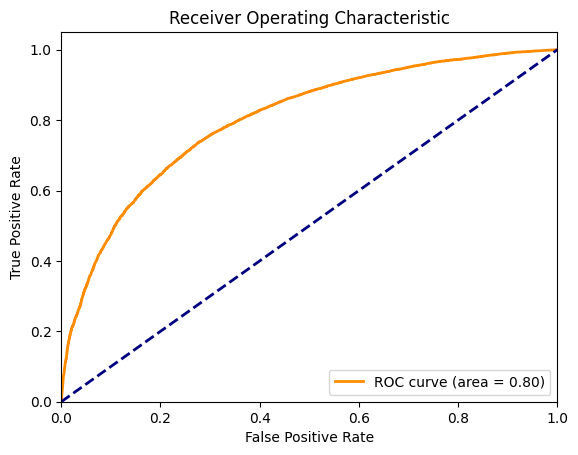

In [343]:
# Obtain predicted probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Cross Validation

* Uses the classifier model created for the RandomForest model after GridSearch.

In [344]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Create the KFold object
k = 5 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42) # Shuffle to shuffle the data

# Create the model
model = classifier

fold = 1

# Initialises lists to store actual and predicted labels
y_true_all = []
y_pred_all = []

# Loop for each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print the results for this fold
    print('Fold:', fold, 'Accuracy:', accuracy)
    
    # Increment the fold counter for the next iteration
    fold += 1 # Go to the next fold

    # Stores the actual and predicted labels to calculate the confusion matrix later
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

Fold: 1 Accuracy: 0.7293346774193549
Fold: 2 Accuracy: 0.7324260752688172
Fold: 3 Accuracy: 0.7293591854565006
Fold: 4 Accuracy: 0.7289559461003394
Fold: 5 Accuracy: 0.7279478477099365
Confusion matrix:
[[48716 20172]
 [20062 59847]]


### Confusion MAtrix

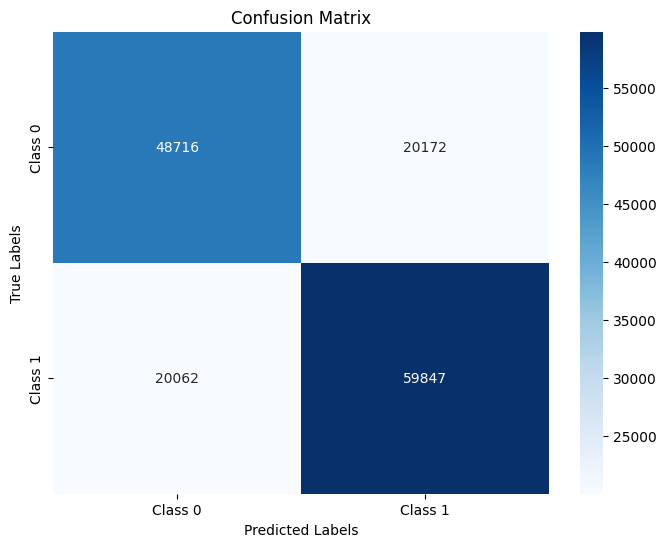

     Class  Precision    Recall  F1 Score
0  Class 0   0.707620  0.702483  0.705042
1  Class 1   0.745228  0.749891  0.747552

Accuracy: 0.7279478477099365


In [345]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the precision, recovery, F1 score and accuracy for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Display the metrics
metrics = {
    "Class": ["Class 0", "Class 1"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")


### ROC Curve

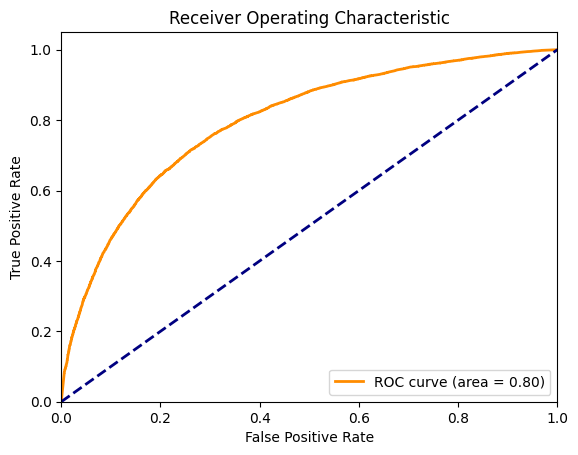

In [346]:
# Obtain predicted probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [347]:
data_copy.head()

,idstore,selling_square_ft,sku,oldpvp,new_pvp,discount,weight (g),margin (%),expected_profit,perc_expiring_sku,...,brand_marca7,brand_outras marcas,selling_square_interval _[0 - 2000[,selling_square_interval _[10000 - 12000[,selling_square_interval _[12000 - 14000[,selling_square_interval _[14000 - ],selling_square_interval _[2000 - 4000[,selling_square_interval _[4000 - 6000[,selling_square_interval _[6000 - 8000[,selling_square_interval _[8000 - 10000[
0,1,4762,1,4.22,2.11,0.5,260.0,16,0.3376,0.010050,...,False,True,False,False,False,False,False,True,False,False
1,1,4762,1,3.96,1.98,0.5,260.0,16,0.3168,0.005025,...,False,True,False,False,False,False,False,True,False,False
2,1,4762,1,4.74,2.37,0.5,260.0,16,0.3792,0.010050,...,False,True,False,False,False,False,False,True,False,False
3,1,4762,1,4.20,2.10,0.5,260.0,16,0.3360,0.010050,...,False,True,False,False,False,False,False,True,False,False
4,1,4762,1,4.62,2.31,0.5,260.0,16,0.3696,0.010050,...,False,True,False,False,False,False,False,True,False,False


# Gini importance

In [348]:
model_dataset.head()

,perc_expiring_sku,new_pvp,selling_square_ft,average_profit_3days_sku,average_shelf_life_3days_prev,sold
0,0.010050,2.11,4762,0.0,0.0,True
1,0.005025,1.98,4762,0.0,0.0,False
2,0.010050,2.37,4762,0.0,0.0,True
3,0.010050,2.10,4762,0.0,0.0,True
4,0.010050,2.31,4762,0.0,0.0,True


In [349]:
target_column = "sold"

# Creates a list of columns without the target column
feature_names = [col for col in model_dataset.columns if col != target_column]

print("List of features without target:", feature_names)

List of features without target: ['perc_expiring_sku', 'new_pvp', 'selling_square_ft', 'average_profit_3days_sku', 'average_shelf_life_3days_prev']


In [350]:
def list_length(feature_namess):
    """Returns the number of elements in the list."""
    return len(feature_names)

print(list_length(feature_names))

5


In [351]:
# Built-in feature importance (Gini Importance)
importances = classifier.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

                         Feature  Gini Importance
2              selling_square_ft         0.498362
3       average_profit_3days_sku         0.194427
4  average_shelf_life_3days_prev         0.126768
1                        new_pvp         0.121678
0              perc_expiring_sku         0.058766


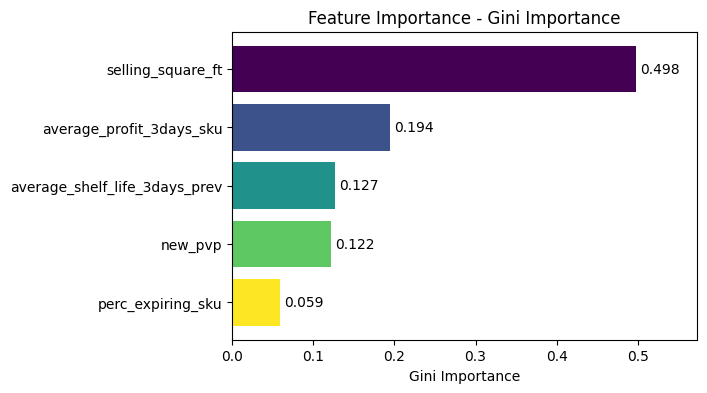

In [352]:
#Plots a horizontal bar chart of feature importances, sorted in descending order.

def plot_sorted_feature_importance(feature_names, importances):
    importances = np.array(importances)  # Ensure importances is a NumPy array
    indices = np.argsort(importances)[::-1]  # Indices sorted in descending order
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(6, 4))

    # Set the colors for the bars
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_importances)))

    bars = plt.barh(sorted_feature_names, sorted_importances, color=colors)

    plt.xlabel('Gini Importance')
    plt.title('Feature Importance - Gini Importance')
    plt.gca().invert_yaxis()

    # Add the values of each bar
    # Adds the values of each bar outside the bar, but within the chart boundary
    for bar in bars:
        width = bar.get_width()
        # Adds a small space between the slash and the text
        space = 0.01 * max(sorted_importances)
        plt.text(width + space, bar.get_y() + bar.get_height() / 2,
                f'{width:.3f}', ha='left', va='center')
    
    # Adjust the x-axis limits to ensure that the text stays within the graph
    plt.xlim(0, max(sorted_importances) * 1.15)

    plt.show()

plot_sorted_feature_importance(feature_names, importances)

# Making a predicition

In [355]:
prediction = classifier.predict(X_train)

# Display the preciction
print(f"The predicition is: {prediction[1]}")

The predicition is: False


In [356]:
actual_target = model_dataset['sold'][1] 

print(f"The value of the target is: {actual_target}")

The value of the target is: False


# Save the model

In [101]:
import pickle

In [ ]:
model = classifier

# Save the model to a file
filename = 'model_forecast_sales_pink_labels.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f'Model saved as {filename}')

# To load the saved model:
# with open(filename, ‘rb’) as file:
# loaded_model = pickle.load(file)

# Now you can use loaded_model to make predictions
# y_pred_loaded = loaded_model.predict(X_test)

Modelo salvo como modelo_previsão_venda_pink_labels.pkl
